In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

#pip3 install -U scikit-learn go download first!!!

In [2]:
data = pd.read_csv('..\..\..\..\listings.csv') #Importing Dataset
        
data_Numeric = pd.DataFrame(data[["id","host_total_listings_count","zipcode","latitude","longitude","accommodates","bathrooms","bedrooms","beds","price","weekly_price","monthly_price","security_deposit","cleaning_fee","guests_included","extra_people","minimum_nights","maximum_nights","availability_30","availability_90","availability_365","number_of_reviews","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","reviews_per_month"]])

for var in data_Numeric:
    if(data_Numeric[var].dtypes == "object"):
        data_Numeric[var] = data_Numeric[var].str.replace(',', '').str.replace('$', '')
        data_Numeric[var] = data_Numeric[var].apply(pd.to_numeric,errors='coerce')

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=9)
data_Numeric_changed = pd.DataFrame(imputer.fit_transform(data_Numeric), columns =data_Numeric.columns)


price_changed = pd.DataFrame(data_Numeric_changed["price"])
reviewscore_changed = pd.DataFrame(data_Numeric_changed["review_scores_rating"])

useless = ["zipcode","latitude","longitude","weekly_price","monthly_price"]
data_Numeric_changed=data_Numeric_changed.drop(axis=1,columns=useless)


data_Numeric_changed.head()

,id,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,241032.0,3.0,4.0,1.0,1.0,1.0,85.0,171.666667,44.444444,2.0,...,346.0,207.0,95.0,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,4.070000
1,953595.0,6.0,4.0,1.0,1.0,1.0,150.0,100.000000,40.000000,1.0,...,291.0,43.0,96.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.480000
2,3308979.0,2.0,11.0,4.5,5.0,7.0,975.0,1000.000000,300.000000,10.0,...,220.0,20.0,97.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.150000
3,7421966.0,1.0,3.0,1.0,0.0,2.0,100.0,277.777778,43.333333,1.0,...,143.0,0.0,96.0,9.777778,9.777778,9.777778,9.666667,8.555556,9.333333,1.848889
4,278830.0,2.0,6.0,2.0,3.0,3.0,450.0,700.000000,125.000000,6.0,...,365.0,38.0,92.0,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.890000


In [10]:
from sklearn.model_selection import train_test_split

data_Numeric_Train, data_Numeric_test,price_Train, price_test,reviewscore_Train, reviewscore_test = train_test_split(data_Numeric_changed,price_changed,reviewscore_changed,test_size = 0.10)

print("Train Set :", data_Numeric_Train.shape, price_Train.shape, reviewscore_Train.shape)
print("Test Set  :", data_Numeric_test.shape, price_test.shape, reviewscore_test.shape)

Train Set : (3436, 25) (3436, 1) (3436, 1)
Test Set  : (382, 25) (382, 1) (382, 1)


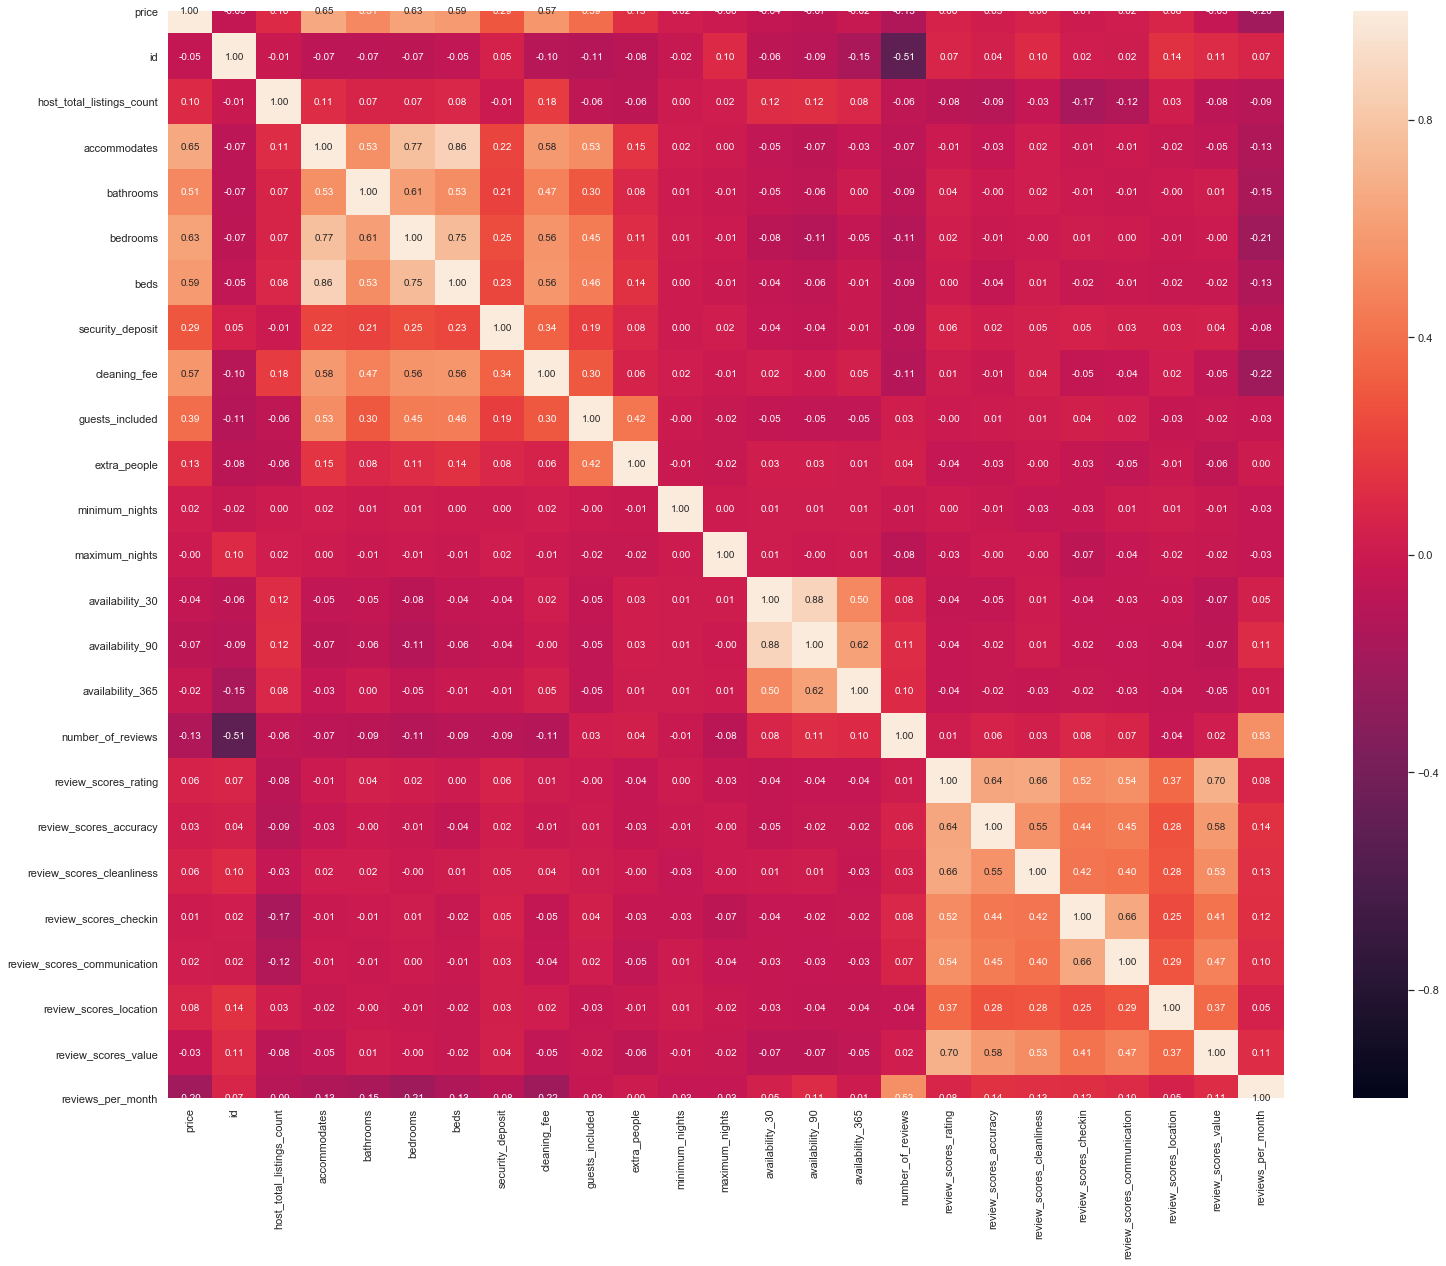

In [11]:
# Correlation between Response and the Predictors
trainDF = pd.concat([price_Train, data_Numeric_Train.reindex(index=data_Numeric_Train.index)], sort = False)

f, axes = plt.subplots(1, 1, figsize=(25, 20))
sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

In [12]:
count = 0
highrelation = []
for var in trainDF.corr():
    if(trainDF.corr()['price'][count] > 0.5):
        print("Variables that are Highly Related:",var)
        if(var != "price"):
            highrelation.append(var) 
    count+=1
    
index = 0
index2 = 0
Multi_High_Related_Train = {} 
Multi_High_Related_Test = {}

for var in highrelation:
    if(index < len(highrelation)):
        Multi_High_Related_Train[index]={} 
        Multi_High_Related_Test[index]={} 
        index+=1
        
index = 0
for var in highrelation:
    for var2 in highrelation:        
        if(var2 != var and index<len(highrelation)):
            Multi_High_Related_Train[index][index2] = pd.DataFrame(data_Numeric_Train[[var,var2]])
            Multi_High_Related_Test[index][index2] = pd.DataFrame(data_Numeric_test[[var,var2]])
            index2+=1
    index2=0
    index+=1



Variables that are Highly Related: price
Variables that are Highly Related: accommodates
Variables that are Highly Related: bathrooms
Variables that are Highly Related: bedrooms
Variables that are Highly Related: beds
Variables that are Highly Related: cleaning_fee


In [13]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression

index = 0
linreg = {}

for var in Multi_High_Related_Train:
    if(index < len(Multi_High_Related_Train)):
        linreg[index]={} 
        index+=1
        
index = 0
index2 = 0
for var in Multi_High_Related_Train:
    for var2 in Multi_High_Related_Train[var]:
        linreg[index][index2] = LinearRegression()
        linreg[index][index2].fit(Multi_High_Related_Train[index][index2], price_Train)
        index2+=1
    index2=0
    index+=1

In [14]:
index = 0
price_train_pred = {}
price_test_pred = {}

for var in linreg:
    if(index < len(linreg)):
        price_train_pred[index]={} 
        price_test_pred[index]={} 
        index+=1

index = 0
index2 = 0
for var in linreg:
    for var2 in linreg[var]:
        price_train_pred[index][index2] = linreg[index][index2].predict(Multi_High_Related_Train[index][index2])
        price_test_pred[index][index2] = linreg[index][index2].predict(Multi_High_Related_Test[index][index2])
        index2+=1
    index2=0
    index+=1

In [17]:
index = 0
index2 = 0

# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error


for var in price_train_pred:
    for var2 in price_train_pred[var]:
        if(linreg[index][index2].score(Multi_High_Related_Train[index][index2], price_Train)>0.47):
            print("For [",var,"][",var2,"]")
            print(Multi_High_Related_Train[index][index2].columns)
            print("Train Explained Variance (R^2) \t:", linreg[index][index2].score(Multi_High_Related_Train[index][index2], price_Train))
            print("Test Explained Variance (R^2) \t:", linreg[index][index2].score(Multi_High_Related_Test[index][index2], price_test))
            print()
        
        index2+=1
    index2=0
    index+=1

For [ 0 ][ 3 ]
Index(['accommodates', 'cleaning_fee'], dtype='object')
Train Explained Variance (R^2) 	: 0.4797886017296512
Test Explained Variance (R^2) 	: 0.4694108702706201

For [ 4 ][ 0 ]
Index(['cleaning_fee', 'accommodates'], dtype='object')
Train Explained Variance (R^2) 	: 0.4797886017296512
Test Explained Variance (R^2) 	: 0.4694108702706201



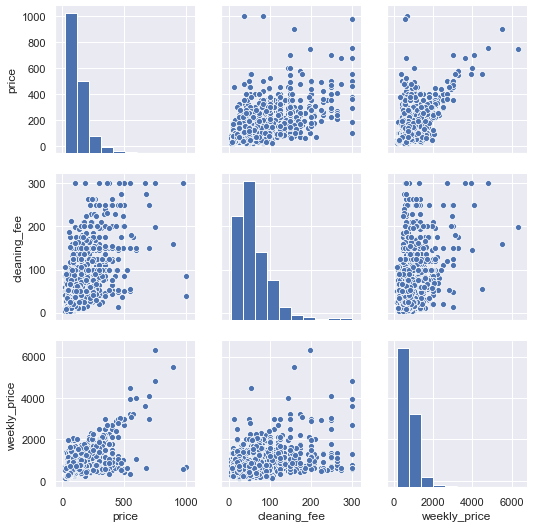

In [33]:

Multi_trainDF = pd.concat([price_Train, Multi_High_Related_Train[4][3].reindex(index=price_Train.index)], sort = False, axis = 1)
sb.pairplot(data = Multi_trainDF)

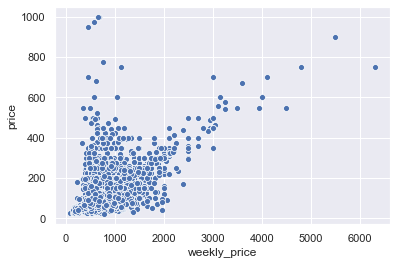

In [34]:
sb.scatterplot(x=data_Numeric_changed['weekly_price'],y=price_changed['price'])

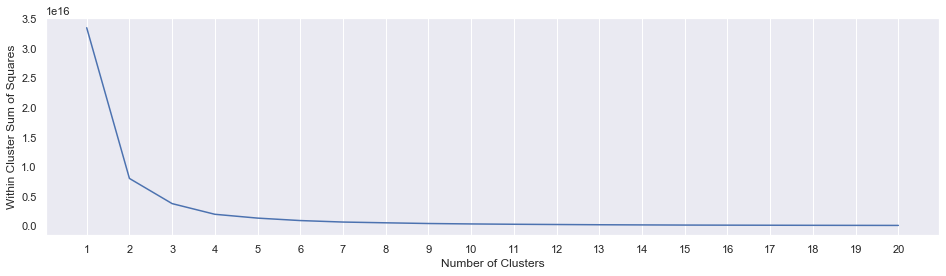

In [101]:
# Import KMeans from sklearn.cluster
from sklearn.cluster import KMeans

# Extract the Features from the Data
X = pd.DataFrame(data_Numeric_changed[["price", "accommodates"]])

# Vary the Number of Clusters
min_clust = 1
max_clust = 20

# Compute Within Cluster Sum of Squares
within_ss = []
for num_clust in range(min_clust, max_clust+1):
    kmeans = KMeans(n_clusters = num_clust)
    kmeans.fit(X)
    within_ss.append(kmeans.inertia_)

# Plot Within SS vs Number of Clusters
f, axes = plt.subplots(1, 1, figsize=(16,4))
plt.plot(range(min_clust, max_clust+1), within_ss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.xticks(np.arange(min_clust, max_clust+1, 1.0))
plt.grid(which='major', axis='y')
plt.show()

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(data_Numeric_changed,price_changed)
model.best_params_

{'n_neighbors': 9}